In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import dwave_networkx as dnx
from dwave.system import DWaveSampler, DWaveCliqueSampler, EmbeddingComposite
from networkx.algorithms.approximation import max_clique

from copy import deepcopy

# HeH+ Molecule Hamiltonian

In [2]:
# Dwave sampler
sampler = EmbeddingComposite(DWaveSampler())
sampler_cli= DWaveCliqueSampler()

In [3]:
molename = "HeH+"

In [4]:
df_node = pd.read_csv("dataset_processed/"+f"{molename}-2.1_node.csv").drop(["Unnamed: 0",], axis=1)
df_node["line"] = 1
df_edge = pd.read_csv("dataset_processed/"+f"{molename}-2.1_edge.csv").drop(["Unnamed: 0",], axis=1)

In [5]:
qubits = len(df_node.iloc[0]["Pstring"])
N = qubits

In [6]:
Sp_group = df_node.sample(n=176 if 176 < df_node.shape[0] else df_node.shape[0])["Pstring"]
Sp_group_I = Sp_group.drop(labels=[0])

In [10]:
# Small Examples

edge_sampled = df_edge.loc[df_edge["source"].isin(Sp_group_I)|df_edge["target"].isin(Sp_group_I)]
edge_sampled = edge_sampled.loc[edge_sampled["source"] != "IIII"]

G_sample =  nx.from_pandas_edgelist(edge_sampled, source='source', target='target', edge_attr
=['commute', "weight"])
G_commute = nx.from_pandas_edgelist(edge_sampled.loc[edge_sampled["commute"]])

In [11]:
edgelist_commute= list(edge_sampled.loc[edge_sampled["commute"]][["source","target"]].itertuples(index=False,name=None))

In [12]:
g_classic = deepcopy(G_commute)
# Classic Clique finder
max_cliques = []
while len(g_classic.nodes) >0:
    clique = max_clique(g_classic)
    max_cliques.append(clique)
    for node in clique:
        g_classic.remove_node(node)


In [13]:
print("Classic Clique solver:")
print("Partition:", len(max_cliques))
for c in max_cliques:
    print(len(c), end=", ")

Classic Clique solver:
Partition: 4
10, 6, 6, 4, 

In [21]:
g_quantum = deepcopy(G_commute)
max_cliques_q = []
while len(g_quantum.nodes) >0:
    clique = dnx.maximum_clique(g_quantum, sampler = sampler_cli)
    max_cliques_q.append(clique)
    for node in clique:
        g_quantum.remove_node(node)

In [22]:
print("Classic Clique solver:")
print("Partition:", len(max_cliques_q))
for c in max_cliques_q:
    print(len(c), end=", ")
print("")
print("Commute test of quantum solver result")
for c in max_cliques_q:
    edges_of_clique = edge_sampled.loc[edge_sampled.source.isin(c) & edge_sampled.target.isin(c)]
    print("Mutually Commute") if edges_of_clique.loc[edges_of_clique["commute"] == False].shape[0] ==0 else print("Not")


Classic Clique solver:
Partition: 3
10, 8, 8, 
Commute test of quantum solver result
Mutually Commute
Mutually Commute
Mutually Commute


In [23]:
c_colors =["red", "green", "yellow", "purple", "brown"]
pos = nx.spring_layout(G_sample)
#kamada_kawai

/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_13604/791848530.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


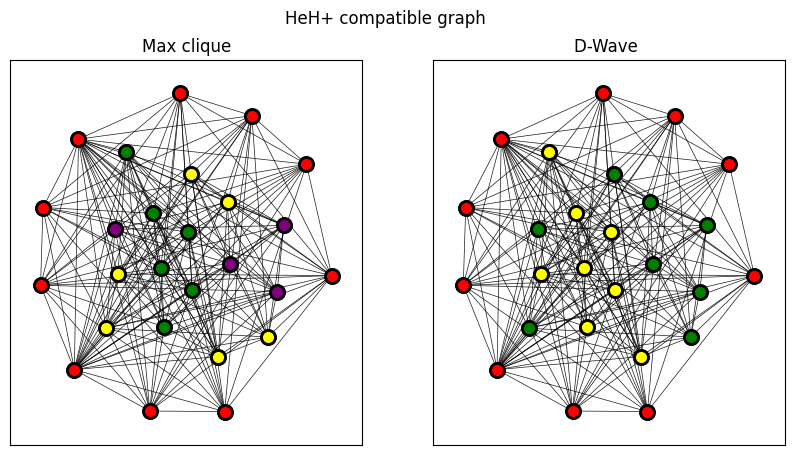

In [24]:
# Plot Graph
fig1, axes = plt.subplots(1,2, figsize = (10, 5))
for ax in axes:
    edges = nx.draw_networkx_edges(
        G_sample, pos, 
        edgelist=edgelist_commute,
        width=0.5, alpha=0.9,
        ax=ax)
    nodes = nx.draw_networkx_nodes(
        G_sample, pos=pos,
        node_size = 100,
        linewidths = 2,
        nodelist=G_sample.nodes,
        label = G_sample.nodes,
        edgecolors="black",
        ax=ax
    )
cliques_c = [max_cliques, max_cliques_q]
for ax, clique_c in zip(axes,cliques_c):
    for clique, color in zip(clique_c, c_colors):
        nx.draw_networkx_nodes(
            G_sample, pos=pos,
            node_size = 100,
            linewidths = 2,
            nodelist=clique,
            edgecolors="black",
            node_color=color,
            ax=ax
        )
axes[0].set_title("Max clique")
axes[1].set_title("D-Wave ")
fig1.suptitle(f"{molename} compatible graph")
fig1.show()

In [105]:
# Find Clique with Direct Sampler
mu0 = -1
mu1 = N*abs(mu0) + 1

In [106]:
df_qubo = pd.DataFrame(columns = ["p1", "p2", "weight"])
df_qubo["p1"] = df_node[df_node["Pstring"]!= "IIII"]["Pstring"]
df_qubo["p2"] = df_node[df_node["Pstring"]!= "IIII"]["Pstring"]
df_qubo["weight"] = 1

In [107]:
df_w_qubo = deepcopy(df_qubo)
df_w_edge = deepcopy(edge_sampled[["source", "target", "commute", "weight"]])
df_w_edge = df_w_edge.loc[df_w_edge["source"] != "IIII"]

In [108]:
h_l =  df_w_qubo.set_index(["p1", "p2"])["weight"].multiply(mu0).to_dict()
q_series = df_w_edge.set_index(["source", "target"])["commute"].astype(int).mul(-1).add(1)
q_commute_series = q_series.multiply(mu1)
Q = q_commute_series.to_dict()
H = {**h_l, **Q}

In [109]:
def get_mark(sampleset, i=0):
    return list(pd.Series(list(sampleset.lowest())[i].keys())[sampleset.lowest().record[i][0].astype(bool)])


In [110]:
clique_coll = []

while df_w_qubo.shape[0] >0:
    sample_q_dwave = sampler.sample_qubo(H, num_reads=100, annealing_time= 2)
    clique =get_mark(sample_q_dwave)
    
    clique_coll.append(clique)
    
    print(clique)
    #----
    #for node in clique:
    #    # Df node drop
    #    # ,,,
    #    pass
    df_w_qubo.drop(df_w_qubo[df_w_qubo["p1"].isin(clique)].index, inplace=True)
    drop_index = df_w_edge[df_w_edge["source"].isin(clique) | df_w_edge["target"].isin(clique)].index
    df_w_edge.drop(drop_index, inplace=True)

    #----
    h_l =  df_w_qubo.set_index(["p1", "p2"])["weight"].multiply(mu0).to_dict()
    q_series = df_w_edge.set_index(["source", "target"])["commute"].astype(int).mul(-1).add(1)
    q_commute_series = q_series.multiply(mu1)
    #q_weight_series = df_edge.set_index(["source","target"])["weight"].multiply(mu2)
    Q = q_commute_series.to_dict()
    #q_commute_series.multiply(q_weight_series).to_dict()
    H = {**h_l, **Q}
    print(f"D shape: {df_w_qubo.shape[0]}")
    #print(df_w_qubo)


['IIIZ', 'IZII', 'IZIZ', 'XIXI', 'XZXI', 'XZXZ', 'YIYI', 'YZYI', 'YZYZ', 'ZIZI']
D shape: 16
['IIZZ', 'IZZI', 'XXYY', 'XYYX', 'YXXY', 'YYXX', 'ZIIZ', 'ZZII']
D shape: 8
['IIZI', 'IXIX', 'IXZX', 'IYIY', 'IYZY', 'ZIII', 'ZXZX', 'ZYZY']
D shape: 0


In [111]:
clique_coll

[['IIIZ',
  'IZII',
  'IZIZ',
  'XIXI',
  'XZXI',
  'XZXZ',
  'YIYI',
  'YZYI',
  'YZYZ',
  'ZIZI'],
 ['IIZZ', 'IZZI', 'XXYY', 'XYYX', 'YXXY', 'YYXX', 'ZIIZ', 'ZZII'],
 ['IIZI', 'IXIX', 'IXZX', 'IYIY', 'IYZY', 'ZIII', 'ZXZX', 'ZYZY']]

In [112]:
print("Classic Clique solver:")
print("Partition:", len(clique_coll))
for c in clique_coll:
    print(len(c), end=", ")
print("")
print("Commute test of quantum solver result")
for c in clique_coll:
    edges_of_clique = edge_sampled.loc[edge_sampled.source.isin(c) & edge_sampled.target.isin(c)]
    print("Mutually Commute") if edges_of_clique.loc[edges_of_clique["commute"] == False].shape[0] ==0 else print("Not")


Classic Clique solver:
Partition: 3
10, 8, 8, 
Commute test of quantum solver result
Mutually Commute
Mutually Commute
Mutually Commute


/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_13604/527504037.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


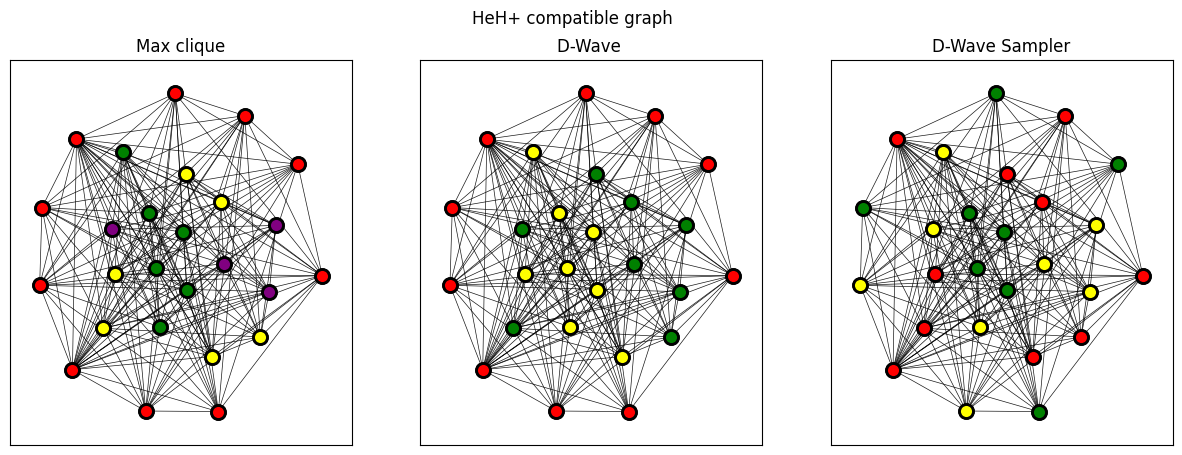

In [113]:
# Plot Graph
fig2, axes = plt.subplots(1,3, figsize = (15, 5))
for ax in axes:
    edges = nx.draw_networkx_edges(
        G_sample, pos, 
        edgelist=edgelist_commute,
        width=0.5, alpha=0.9,
        ax=ax)
    nodes = nx.draw_networkx_nodes(
        G_sample, pos=pos,
        node_size = 100,
        linewidths = 2,
        nodelist=G_sample.nodes,
        label = G_sample.nodes,
        edgecolors="black",
        ax=ax
    )
cliques_c = [max_cliques, max_cliques_q, clique_coll]
for ax, clique_c in zip(axes,cliques_c):
    for clique, color in zip(clique_c, c_colors):
        nx.draw_networkx_nodes(
            G_sample, pos=pos,
            node_size = 100,
            linewidths = 2,
            nodelist=clique,
            edgecolors="black",
            node_color=color,
            ax=ax
        )
axes[0].set_title("Max clique")
axes[1].set_title("D-Wave ")
axes[2].set_title("D-Wave Sampler")
fig2.suptitle(f"{molename} compatible graph")
fig2.show()

In [58]:
from math import fabs

In [98]:
# Find Clique with Direct Sampler
mu2 = 0.5
mu0 = -(0.5*N*(N-1)*abs(mu2)+1)
mu1 = N*fabs(mu0) + 1

In [99]:
df_w_qubo2 = deepcopy(df_qubo)
df_w_edge2 = deepcopy(edge_sampled[["source", "target", "commute", "weight"]])
df_w_edge2 = df_w_edge2.loc[df_w_edge2["source"] != "IIII"]

In [100]:
h_l2 =  df_w_qubo2.set_index(["p1", "p2"])["weight"].multiply(mu0).to_dict()

q_series2 = df_w_edge2.set_index(["source", "target"])["commute"].astype(int).mul(-1).add(1)
q_commute_series2 = q_series2.multiply(mu1)
q_weight_series2 = df_w_edge2.set_index(["source","target"])["weight"].multiply(mu2)

Q2 = q_commute_series2.multiply(q_weight_series2).to_dict()
H2 = {**h_l2, **Q2}

In [101]:
clique_coll2 = []

while df_w_qubo2.shape[0] >0:
    sample_q_dwave2 = sampler.sample_qubo(H2, num_reads=100, annealing_time= 2)
    
    clique2 =get_mark(sample_q_dwave2)
    
    clique_coll2.append(clique2)
    
    print(clique2)

    #----
    df_w_qubo2.drop(df_w_qubo2[df_w_qubo2["p1"].isin(clique2)].index, inplace=True)
    drop_index2 = df_w_edge2[df_w_edge2["source"].isin(clique2) | df_w_edge2["target"].isin(clique2)].index
    df_w_edge2.drop(drop_index2, inplace=True)

    #----
    h_l2 =  df_w_qubo2.set_index(["p1", "p2"])["weight"].multiply(mu0).to_dict()

    q_series2 = df_w_edge2.set_index(["source", "target"])["commute"].astype(int).mul(-1).add(1)
    q_commute_series2 = q_series2.multiply(mu1)
    q_weight_series2 = df_w_edge2.set_index(["source","target"])["weight"].multiply(mu2)

    Q2 = q_commute_series2.multiply(q_weight_series2).to_dict()
    H2 = {**h_l2, **Q2}
    print(f"D shape: {df_w_qubo2.shape[0]}")


['IXIX', 'IYIY', 'IZIZ', 'XIXI', 'XZXZ', 'YIYI', 'YZYZ', 'ZIZI', 'ZXZX', 'ZYZY']
D shape: 16
['IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZZI', 'ZIII', 'ZIIZ', 'ZZII']
D shape: 8
['IXZX', 'IYZY', 'XXYY', 'XYYX', 'XZXI', 'YXXY', 'YYXX', 'YZYI']
D shape: 0


In [102]:
clique_coll2

[['IXIX',
  'IYIY',
  'IZIZ',
  'XIXI',
  'XZXZ',
  'YIYI',
  'YZYZ',
  'ZIZI',
  'ZXZX',
  'ZYZY'],
 ['IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZZI', 'ZIII', 'ZIIZ', 'ZZII'],
 ['IXZX', 'IYZY', 'XXYY', 'XYYX', 'XZXI', 'YXXY', 'YYXX', 'YZYI']]

In [103]:
cli_check = clique_coll2
print("Classic Clique solver:")
print("Partition:", len(cli_check))
for c in cli_check:
    print(len(c), end=", ")
print("")
print("Commute test of quantum solver result")
for c in cli_check:
    edges_of_clique = edge_sampled.loc[edge_sampled.source.isin(c) & edge_sampled.target.isin(c)]
    print("Mutually Commute") if edges_of_clique.loc[edges_of_clique["commute"] == False].shape[0] ==0 else print("Not")


Classic Clique solver:
Partition: 3
10, 8, 8, 
Commute test of quantum solver result
Mutually Commute
Mutually Commute
Mutually Commute


/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_13604/353237904.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


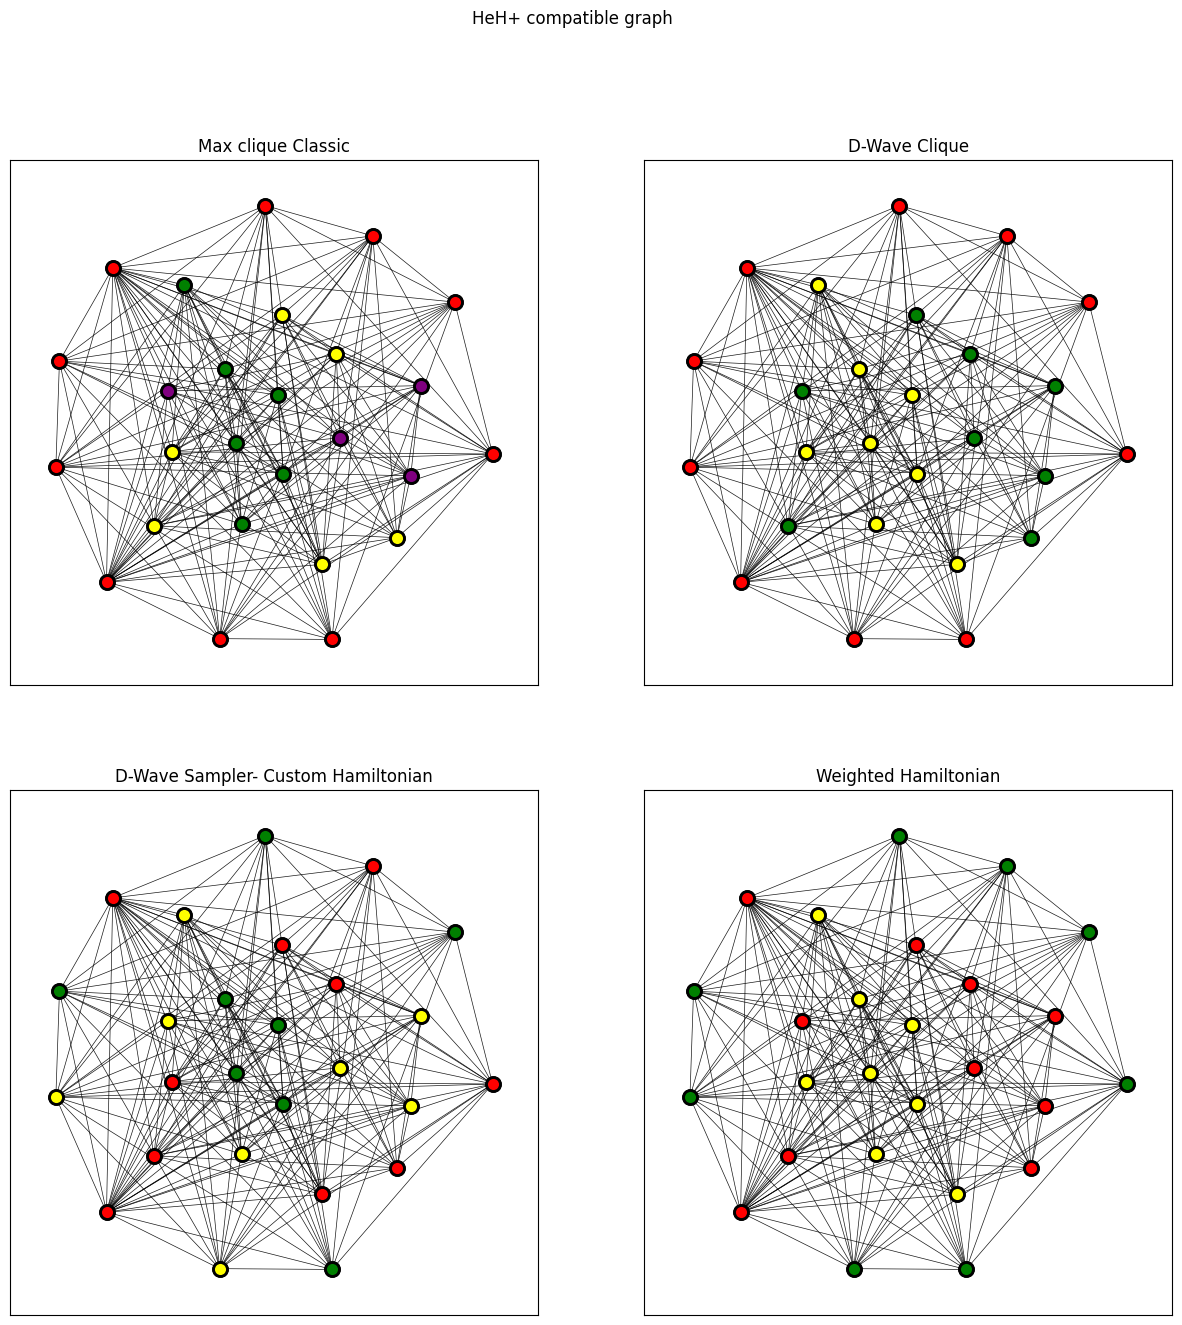

In [114]:
# Plot Graph
fig2, axes = plt.subplots(2,2, figsize = (15, 15))

for ax in axes.reshape(-1):
    edges = nx.draw_networkx_edges(
        G_sample, pos, 
        edgelist=edgelist_commute,
        width=0.5, alpha=0.9,
        ax=ax)
    nodes = nx.draw_networkx_nodes(
        G_sample, pos=pos,
        node_size = 100,
        linewidths = 2,
        nodelist=G_sample.nodes,
        label = G_sample.nodes,
        edgecolors="black",
        ax=ax
    )
cliques_c = [max_cliques, max_cliques_q, clique_coll, clique_coll2]
for ax, clique_c in zip(axes.reshape(-1),cliques_c):
    for clique, color in zip(clique_c, c_colors):
        nx.draw_networkx_nodes(
            G_sample, pos=pos,
            node_size = 100,
            linewidths = 2,
            nodelist=clique,
            edgecolors="black",
            node_color=color,
            ax=ax
        )
axes[0][0].set_title("Max clique Classic")
axes[0][1].set_title("D-Wave Clique")
axes[1][0].set_title("D-Wave Sampler- Custom Hamiltonian")
axes[1][1].set_title("Weighted Hamiltonian")
fig2.suptitle(f"{molename} compatible graph")
fig2.show()

In [115]:
for c in cliques_c:
    print(c)

[{'ZZII', 'IZZI', 'ZIIZ', 'IZIZ', 'IIIZ', 'IZII', 'ZIZI', 'IIZI', 'ZIII', 'IIZZ'}, {'XXYY', 'YXXY', 'IXZX', 'IYZY', 'YYXX', 'XYYX'}, {'YZYI', 'YZYZ', 'YIYI', 'XZXI', 'XZXZ', 'XIXI'}, {'IYIY', 'IXIX', 'ZXZX', 'ZYZY'}]
[['IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'ZIII', 'ZIIZ', 'ZIZI', 'ZZII'], ['IXIX', 'IYIY', 'XIXI', 'XZXZ', 'YIYI', 'YZYZ', 'ZXZX', 'ZYZY'], ['IXZX', 'IYZY', 'XXYY', 'XYYX', 'XZXI', 'YXXY', 'YYXX', 'YZYI']]
[['IIIZ', 'IZII', 'IZIZ', 'XIXI', 'XZXI', 'XZXZ', 'YIYI', 'YZYI', 'YZYZ', 'ZIZI'], ['IIZZ', 'IZZI', 'XXYY', 'XYYX', 'YXXY', 'YYXX', 'ZIIZ', 'ZZII'], ['IIZI', 'IXIX', 'IXZX', 'IYIY', 'IYZY', 'ZIII', 'ZXZX', 'ZYZY']]
[['IXIX', 'IYIY', 'IZIZ', 'XIXI', 'XZXZ', 'YIYI', 'YZYZ', 'ZIZI', 'ZXZX', 'ZYZY'], ['IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZZI', 'ZIII', 'ZIIZ', 'ZZII'], ['IXZX', 'IYZY', 'XXYY', 'XYYX', 'XZXI', 'YXXY', 'YYXX', 'YZYI']]


---

In [116]:
Clique_Set_HeH ={
    "Classic": { f"p{i}": list(z) for i, z in enumerate(cliques_c[0])},
    "Dwave" :{ f"p{i}": list(z) for i, z in enumerate(cliques_c[1])},
    "Dwave_custom":{ f"p{i}": list(z) for i, z in enumerate(cliques_c[2])},
    "Dwave_custom_w": { f"p{i}": list(z) for i, z in enumerate(cliques_c[3])}
}

In [117]:
Clique_Set_HeH["Dwave_custom_w"]

{'p0': ['IXIX',
  'IYIY',
  'IZIZ',
  'XIXI',
  'XZXZ',
  'YIYI',
  'YZYZ',
  'ZIZI',
  'ZXZX',
  'ZYZY'],
 'p1': ['IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZZI', 'ZIII', 'ZIIZ', 'ZZII'],
 'p2': ['IXZX', 'IYZY', 'XXYY', 'XYYX', 'XZXI', 'YXXY', 'YYXX', 'YZYI']}

In [158]:
edgelist = edge_sampled[["source","target","commute","weight"]]

In [159]:
edgelist["PartI"] = "p"
edgelist["PartF"] = "p"
edgelist = edgelist.reset_index(drop=True)

/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_13604/1153943630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edgelist["PartI"] = "p"
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_13604/1153943630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edgelist["PartF"] = "p"


In [160]:
for p in Clique_Set_HeH["Dwave_custom_w"].keys():
    print(p)
    edgelist.loc[edgelist["source"].isin(Clique_Set_HeH["Dwave_custom_w"][p]), ["PartI"]] = p
    edgelist.loc[edgelist["target"].isin(Clique_Set_HeH["Dwave_custom_w"][p]), ["PartF"]] = p

p0
p1
p2


In [164]:
edgelist.head(10)

,source,target,commute,weight,PartI,PartF
0,IIIZ,IIZI,True,0.0,p1,p1
1,IIIZ,IIZZ,True,0.0,p1,p1
2,IIIZ,IZII,True,0.0,p1,p1
3,IIIZ,IZIZ,True,0.0,p1,p0
4,IIIZ,IZZI,True,0.0,p1,p1
5,IIIZ,ZIII,True,0.0,p1,p1
6,IIIZ,ZIIZ,True,0.0,p1,p1
7,IIIZ,ZIZI,True,0.0,p1,p0
8,IIIZ,ZZII,True,0.0,p1,p1
9,IIIZ,IXIX,False,0.5,p1,p0


In [163]:
parted_edgelist = edgelist.set_index(["PartI", "PartF"])

source target  commute  weight
PartI PartF                               
p1    p1      IIIZ   IIZI     True     0.0
      p1      IIIZ   IIZZ     True     0.0
      p1      IIIZ   IZII     True     0.0
      p0      IIIZ   IZIZ     True     0.0
      p1      IIIZ   IZZI     True     0.0
...            ...    ...      ...     ...
p2    p0      YYXX   ZYZY    False     1.0
      p0      YYXX   YZYZ    False     1.0
      p0      YZYI   ZYZY    False     2.0
      p0      YZYI   YZYZ     True     0.0
p0    p0      ZYZY   YZYZ     True     2.0

[325 rows x 4 columns]

In [185]:
from itertools import combinations

In [194]:
list(combinations(["p0", "p1", "p2"], 2))

[('p0', 'p1'), ('p0', 'p2'), ('p1', 'p2')]

In [190]:
for pi, pf in list(combinations(["p0", "p1", "p2"], 2)):
    t_edges = edgelist.loc[(edgelist["PartI"] == pf) & (edgelist["PartF"] == pi) ]
    
    s = t_edges["source"]
    t_edges["source"] = t_edges["target"]
    t_edges["target"] = s

    p = t_edges["PartI"]
    t_edges["PartI"] = t_edges["PartF"]
    t_edges["PartF"] = p

    edgelist.loc[(edgelist["PartI"] == pf) & (edgelist["PartF"] == pi) ] = t_edges
    

/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_13604/1959539133.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_edges["source"] = t_edges["target"]
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_13604/1959539133.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_edges["target"] = s
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_13604/1959539133.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [191]:
edgelist

,source,target,commute,weight,PartI,PartF
0,IIIZ,IIZI,True,0.0,p1,p1
1,IIIZ,IIZZ,True,0.0,p1,p1
2,IIIZ,IZII,True,0.0,p1,p1
3,IZIZ,IIIZ,True,0.0,p0,p1
4,IIIZ,IZZI,True,0.0,p1,p1
...,...,...,...,...,...,...
320,ZYZY,YYXX,False,1.0,p0,p2
321,YZYZ,YYXX,False,1.0,p0,p2
322,ZYZY,YZYI,False,2.0,p0,p2
323,YZYZ,YZYI,True,0.0,p0,p2


In [192]:
edgelist.loc[(edgelist["PartI"] == "p0") & (edgelist["PartF"] == "p1") ]

,source,target,commute,weight,PartI,PartF
3,IZIZ,IIIZ,True,0.0,p0,p1
7,ZIZI,IIIZ,True,0.0,p0,p1
9,IXIX,IIIZ,False,0.5,p0,p1
10,XIXI,IIIZ,True,0.5,p0,p1
14,IYIY,IIIZ,False,1.0,p0,p1
...,...,...,...,...,...,...
195,XZXZ,ZZII,False,0.5,p0,p1
199,ZXZX,ZZII,False,0.5,p0,p1
200,YIYI,ZZII,False,1.0,p0,p1
203,ZYZY,ZZII,False,1.0,p0,p1


In [204]:
edgelist = edgelist.sort_values(["PartI","PartF"])
edgelist = edgelist.reset_index(drop=True)

In [206]:
edgelist.loc[edgelist["PartI"] == "p0"]

,source,target,commute,weight,PartI,PartF
0,IZIZ,ZIZI,True,0.0,p0,p0
1,IZIZ,IXIX,True,0.5,p0,p0
2,IZIZ,XIXI,True,0.5,p0,p0
3,IZIZ,IYIY,True,1.0,p0,p0
4,IZIZ,XZXZ,True,0.5,p0,p0
...,...,...,...,...,...,...
200,YIYI,YZYI,True,0.0,p0,p2
201,ZYZY,YYXX,False,1.0,p0,p2
202,YZYZ,YYXX,False,1.0,p0,p2
203,ZYZY,YZYI,False,2.0,p0,p2


In [208]:
edgelist.loc[edgelist["PartI"] == "p1"]

,source,target,commute,weight,PartI,PartF
205,IIIZ,IIZI,True,0.0,p1,p1
206,IIIZ,IIZZ,True,0.0,p1,p1
207,IIIZ,IZII,True,0.0,p1,p1
208,IIIZ,IZZI,True,0.0,p1,p1
209,IIIZ,ZIII,True,0.0,p1,p1
...,...,...,...,...,...,...
292,ZZII,XYYX,True,1.5,p1,p2
293,ZZII,IYZY,False,1.0,p1,p2
294,ZZII,YXXY,True,1.5,p1,p2
295,ZZII,YYXX,True,1.5,p1,p2


In [209]:
p0p0 = edgelist.loc[(edgelist["PartI"] == "p0")&(edgelist["PartF"] == "p0")]
p0p1 = edgelist.loc[(edgelist["PartI"] == "p0")&(edgelist["PartF"] == "p1")]
p0p2 = edgelist.loc[(edgelist["PartI"] == "p0")&(edgelist["PartF"] == "p2")]
p1p1 = edgelist.loc[(edgelist["PartI"] == "p1")&(edgelist["PartF"] == "p1")]
p1p2 = edgelist.loc[(edgelist["PartI"] == "p1")&(edgelist["PartF"] == "p2")]
p2p2 = edgelist.loc[(edgelist["PartI"] == "p2")&(edgelist["PartF"] == "p2")]

In [319]:
p0p1_bridge = p0p1.loc[p0p1["weight"] <0.1].sample(n=1)[["source","target"]]
p0p2_bridge = p0p2.loc[p0p2["weight"] <0.1].sample(n=1)[["source","target"]]
p1p2_bridge = p1p2.loc[p1p2["weight"] <0.7].sample(n=1)[["source","target"]]

In [322]:
p1p2_bridge

,source,target
235,IIIZ,XZXI


In [323]:
p0p2_bridge

,source,target
141,IXIX,IXZX


In [232]:
p0p1_bridge

,source,target
98,ZIZI,ZIII


In [324]:
p0_i, p1_i = list(p0p1_bridge.itertuples(index=False, name=None))[0]
p0_f, p2_i = list(p0p2_bridge.itertuples(index=False, name=None))[0]
p1_f, p2_f = list(p1p2_bridge.itertuples(index=False, name=None))[0]
p_bridge= [(p0_i, p0_f), (p1_i, p1_f), (p2_i, p2_f)]
print(p_bridge)

[('ZIZI', 'IXIX'), ('IIZZ', 'IIIZ'), ('IXZX', 'XZXI')]


In [326]:
from networkx.algorithms import approximation as approx

In [342]:
def get_local_path(partitions, bridges):
    cycles = []
    for partition, bridge in zip(partitions, bridges):
        pi, pf = bridge
        g_partition = nx.from_pandas_edgelist(
            partition, 
            source='source', target='target', 
            edge_attr=["weight"])
        try:
            g_partition[pi][pf]["weight"] = -1
        except:
            g_partition[pf][pi]["weight"] = -1

        cycle = approx.greedy_tsp(g_partition, source=pi)
        cycles.append(cycle)
    return cycles

In [343]:
p_bridge

[('ZIZI', 'IXIX'), ('IIZZ', 'IIIZ'), ('IXZX', 'XZXI')]

In [344]:
p0_local, p1_local, p2_local = get_local_path([p0p0, p1p1, p2p2], p_bridge)


In [346]:
p0_local = p0_local[1:]
p1_local = p1_local[1:]
p2_local = p2_local[1:]

In [347]:
p0_local, p1_local, p2_local

(['IXIX',
  'ZXZX',
  'IYIY',
  'ZYZY',
  'IZIZ',
  'XZXZ',
  'XIXI',
  'YZYZ',
  'YIYI',
  'ZIZI'],
 ['IIIZ', 'ZZII', 'IZZI', 'ZIIZ', 'IZII', 'IIZI', 'ZIII', 'IIZZ'],
 ['XZXI', 'YZYI', 'XXYY', 'YXXY', 'YYXX', 'XYYX', 'IYZY', 'IXZX'])

In [309]:
G00 = nx.from_pandas_edgelist(p0p0, source='source', target='target', edge_attr
=["weight"])
print(p0_i, p0_f)

ZIZI ZXZX


In [312]:
G00[p0_f][p0_i]

{'weight': 0.5}

In [218]:
pos = nx.kamada_kawai_layout(G00)

/Users/hyunseongkim/Documents/공부/.conda/lib/python3.11/site-packages/networkx/drawing/layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


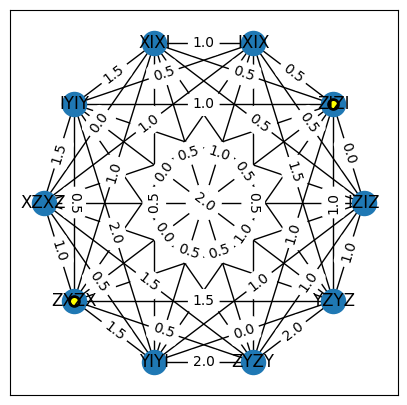

In [244]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
nx.draw_networkx(G00,pos, ax=ax)
labels = nx.get_edge_attributes(G00,'weight')
edge = nx.draw_networkx_edge_labels(G00,pos,edge_labels=labels, ax=ax)
node = nx.draw_networkx_nodes(
        G00, pos=pos,
        node_size = 50,
        node_color="yellow",
        linewidths = 2,
        nodelist=[p0_i, p0_f],
        label = G00.nodes,
        edgecolors="black",
        ax=ax
    )

In [287]:
weight_p0p0 = p0p0.set_index(["source","target"])[["weight"]].to_dict()

In [291]:
list(weight_p0p0["weight"].keys())

[('IZIZ', 'ZIZI'),
 ('IZIZ', 'IXIX'),
 ('IZIZ', 'XIXI'),
 ('IZIZ', 'IYIY'),
 ('IZIZ', 'XZXZ'),
 ('IZIZ', 'ZXZX'),
 ('IZIZ', 'YIYI'),
 ('IZIZ', 'ZYZY'),
 ('IZIZ', 'YZYZ'),
 ('ZIZI', 'IXIX'),
 ('ZIZI', 'XIXI'),
 ('ZIZI', 'IYIY'),
 ('ZIZI', 'XZXZ'),
 ('ZIZI', 'ZXZX'),
 ('ZIZI', 'YIYI'),
 ('ZIZI', 'ZYZY'),
 ('ZIZI', 'YZYZ'),
 ('IXIX', 'XIXI'),
 ('IXIX', 'IYIY'),
 ('IXIX', 'XZXZ'),
 ('IXIX', 'ZXZX'),
 ('IXIX', 'YIYI'),
 ('IXIX', 'ZYZY'),
 ('IXIX', 'YZYZ'),
 ('XIXI', 'IYIY'),
 ('XIXI', 'XZXZ'),
 ('XIXI', 'ZXZX'),
 ('XIXI', 'YIYI'),
 ('XIXI', 'ZYZY'),
 ('XIXI', 'YZYZ'),
 ('IYIY', 'XZXZ'),
 ('IYIY', 'ZXZX'),
 ('IYIY', 'YIYI'),
 ('IYIY', 'ZYZY'),
 ('IYIY', 'YZYZ'),
 ('XZXZ', 'ZXZX'),
 ('XZXZ', 'YIYI'),
 ('XZXZ', 'ZYZY'),
 ('XZXZ', 'YZYZ'),
 ('ZXZX', 'YIYI'),
 ('ZXZX', 'ZYZY'),
 ('ZXZX', 'YZYZ'),
 ('YIYI', 'ZYZY'),
 ('YIYI', 'YZYZ'),
 ('ZYZY', 'YZYZ')]

In [284]:
cycle = approx.greedy_tsp(G00, source=p0_i)
cycle, p0_f

(['ZIZI',
  'IZIZ',
  'IXIX',
  'ZXZX',
  'IYIY',
  'ZYZY',
  'XZXZ',
  'XIXI',
  'YZYZ',
  'YIYI',
  'ZIZI'],
 'ZXZX')

In [298]:
len(G00.nodes)

10

In [297]:
len(cycle)

11

In [299]:
n = len(cycle)
w = 0
for i, c in enumerate(cycle):
    if i != n-1:
        try:
            w+=weight_p0p0["weight"][(cycle[i], cycle[i+1])]
        except:
            w+=weight_p0p0["weight"][(cycle[i+1], cycle[i])]
    else:
        pass
w

4.0

In [282]:
cycle.index(p0_f)

3

In [283]:
from itertools import permutations

$$\mu_1  > N \mu_0,  \, \mu_0 > \frac{1}{2} N(N-1) \mu_2$$